In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

This notebook explores weight decay values for the network. Two of the best performing networks selected.
1. initial_lrate = 1e-2, drop = 0.864065, epochs_drop = 25 EPOCHS=700
2. Triangular Learning rate2	MIN_LR = 6e-4, MAX_LR = 6.6e-3, BATCH_SIZE = 32, STEP_SIZE = 8, CLR_METHOD = "triangular2", EPOCHS = 640

For both these methods, the following weight decay values are tried
1e-3, 1e-2, and 1e-4
and then fine tuning

In [2]:
import os
import shutil
import time
import datetime
import random

import numpy as np

from tensorflow.keras import layers,models,utils,optimizers,regularizers
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import TensorBoard,EarlyStopping,LearningRateScheduler
from util.custom_callbacks import SkipLoggerCallback,StepDecayHistoryCallback
from util.custom_callbacks import step_decay
from util.clr_callback import CyclicLR 

import matplotlib.pyplot as plt

from util.custom_callbacks import step_decay_25_864065

In [3]:
DATA_DIR = 'data/caps_and_shoes_squared/'
IMAGE_SIZE = (28,28)
CLASS_LIST = ['cap','shoes']
BATCH_SIZE = 32

train_path = DATA_DIR + 'train'
validation_path = DATA_DIR + 'val'
test_path = DATA_DIR + 'test'

SOURCE_DATA_DIR = 'data/caps_and_shoes_squared_2/'
TEST_DATA_DIR = 'data/out_of_set_tests/'

In [4]:
def create_test_set(seed=random.randint(1,10000)):

    dirpath = os.path.join(TEST_DATA_DIR, 'temp_test')
    if os.path.exists(dirpath) and os.path.isdir(dirpath):
        shutil.rmtree(dirpath)
        
    os.makedirs(dirpath, exist_ok=True)
    
    for class_name in CLASS_LIST:
        src_dir = os.path.join(SOURCE_DATA_DIR, class_name)
        dest_dir = os.path.join(dirpath, class_name)
        os.makedirs(dest_dir, exist_ok=True)
        
        src_files = (os.listdir(src_dir))
        random.seed(seed)
        choices = random.sample(src_files, 25)
        for file_name in choices:
            shutil.copy(os.path.join(src_dir, file_name), dest_dir)
            
def get_oos_test_accuracy(model=None):
    
    out_test_accuracy_log = []
    
    for iter_count in range(25):
    
        seed = random.randint(1,10000)
        create_test_set(seed)

        test_img_generator = ImageDataGenerator(rescale = 1./255)
        test_batches = test_img_generator.flow_from_directory(os.path.join(TEST_DATA_DIR, 'temp_test'),
                                                              target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                              class_mode = 'categorical', batch_size=32)
        test_loss, test_accuracy = model.evaluate_generator(test_batches, workers=4, verbose=0) 
        out_test_accuracy_log.append(test_accuracy)
    
    return (np.mean(out_test_accuracy_log),np.std(out_test_accuracy_log))

In [5]:
test_img_generator = ImageDataGenerator( rescale = 1./255)
train_validation_img_generator = ImageDataGenerator(validation_split=0.2, rescale = 1./255, rotation_range = 10, width_shift_range = 0.1, height_shift_range=0.1, zoom_range = 0.1, 
                                   horizontal_flip=True, fill_mode='nearest')

train_batches = train_validation_img_generator.flow_from_directory(train_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                  class_mode = 'categorical', batch_size=BATCH_SIZE, subset='training')

validation_batches = train_validation_img_generator.flow_from_directory(train_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                  class_mode = 'categorical', batch_size=BATCH_SIZE, subset='validation')

test_batches = test_img_generator.flow_from_directory(test_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                  class_mode = 'categorical',batch_size=1, shuffle=False)

Found 1832 images belonging to 2 classes.
Found 457 images belonging to 2 classes.
Found 326 images belonging to 2 classes.


In [6]:
def define_model_architecture_64_32_16(optimizer_p = 'sgd',weight_decay=1e-2):
    model = models.Sequential()
    model.add(Flatten(input_shape = (28,28,1)))
    model.add(Dense(64, activation='relu', kernel_regularizer = regularizers.l2(weight_decay)))
    model.add(Dense(32, activation='relu', kernel_regularizer = regularizers.l2(weight_decay)))
    model.add(Dense(16, activation='relu', kernel_regularizer = regularizers.l2(weight_decay)))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer=optimizer_p, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [7]:
weight_decay_list = [1e-2,1e-3,1e-4,1e-5]

In [8]:
learning_history_dict = {}
training_time_dict = {}
out_of_set_test_dict = {}
lr_dict = {}
EPOCHS = 700

In [9]:
!rm -rf ./logs/
skipLogger_callback = SkipLoggerCallback(n=25)

lrate_callback = LearningRateScheduler(step_decay_25_864065)

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    
callback_list = [lrate_callback, tb_callback, skipLogger_callback]

In [10]:
for weight_decay_i in weight_decay_list:
    print('working with weight_decay : %f' % weight_decay_i)
    print('')
    
    sgd = optimizers.SGD(lr=0.0,momentum=0.9,nesterov=True)
    model = define_model_architecture_64_32_16(optimizer_p=sgd,weight_decay=weight_decay_i)
    
    log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    start = time.time()
    history = model.fit_generator(generator = train_batches, steps_per_epoch=train_batches.samples/BATCH_SIZE, 
                                  validation_data = validation_batches, validation_steps = validation_batches.samples/BATCH_SIZE,
                                  epochs=EPOCHS, verbose=0, workers=4, callbacks = callback_list)
    
    training_time_dict[str(weight_decay_i)] = time.time() - start
    learning_history_dict[str(weight_decay_i)] = history
    out_of_set_test_dict[str(weight_decay_i)] = get_oos_test_accuracy(model)
    test_loss, test_accuracy = model.evaluate_generator(test_batches, workers=4, verbose=0) 
    print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))    
    print('-'*120)

working with weight_decay : 0.010000



W0910 09:38:37.097093 140176747939648 deprecation.py:323] From /home/algolaptop8/anaconda3/envs/tf2-env/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


epoch =    0    loss = 2.338156    accuracy = 0.62    val_loss = 2.216976    val_accuracy = 0.65
epoch =   25    loss = 0.617440    accuracy = 0.68    val_loss = 0.692573    val_accuracy = 0.66
epoch =   50    loss = 0.595141    accuracy = 0.71    val_loss = 0.675682    val_accuracy = 0.67
epoch =   75    loss = 0.589310    accuracy = 0.72    val_loss = 0.609936    val_accuracy = 0.72
epoch =  100    loss = 0.570560    accuracy = 0.75    val_loss = 0.665114    val_accuracy = 0.67
epoch =  125    loss = 0.581744    accuracy = 0.74    val_loss = 0.609092    val_accuracy = 0.75
epoch =  150    loss = 0.570053    accuracy = 0.76    val_loss = 0.620166    val_accuracy = 0.74
epoch =  175    loss = 0.550378    accuracy = 0.76    val_loss = 0.613770    val_accuracy = 0.74
epoch =  200    loss = 0.551551    accuracy = 0.76    val_loss = 0.604400    val_accuracy = 0.74
epoch =  225    loss = 0.543943    accuracy = 0.77    val_loss = 0.563353    val_accuracy = 0.75
epoch =  250    loss = 0.55091

epoch =  100    loss = 0.436896    accuracy = 0.81    val_loss = 0.460848    val_accuracy = 0.82
epoch =  125    loss = 0.406225    accuracy = 0.83    val_loss = 0.485016    val_accuracy = 0.80
epoch =  150    loss = 0.399782    accuracy = 0.83    val_loss = 0.461220    val_accuracy = 0.81
epoch =  175    loss = 0.386686    accuracy = 0.83    val_loss = 0.468385    val_accuracy = 0.82
epoch =  200    loss = 0.383406    accuracy = 0.83    val_loss = 0.392459    val_accuracy = 0.84
epoch =  225    loss = 0.369138    accuracy = 0.84    val_loss = 0.444324    val_accuracy = 0.82
epoch =  250    loss = 0.368644    accuracy = 0.84    val_loss = 0.466062    val_accuracy = 0.82
epoch =  275    loss = 0.343249    accuracy = 0.86    val_loss = 0.470190    val_accuracy = 0.84
epoch =  300    loss = 0.320351    accuracy = 0.87    val_loss = 0.405517    val_accuracy = 0.85
epoch =  325    loss = 0.324986    accuracy = 0.86    val_loss = 0.460522    val_accuracy = 0.82
epoch =  350    loss = 0.33583

In [11]:
training_time_dict

{'0.01': 3985.2700169086456,
 '0.001': 3958.8897161483765,
 '0.0001': 3966.8047153949738,
 '1e-05': 3992.054261445999}

In [12]:
out_of_set_test_dict

{'0.01': (0.80165917, 0.0595888),
 '0.001': (0.8323756, 0.059882738),
 '0.0001': (0.86201423, 0.04627483),
 '1e-05': (0.85875916, 0.045764614)}

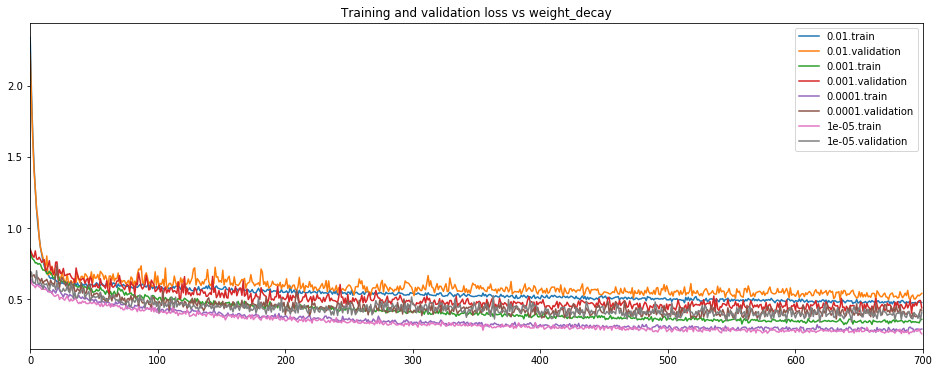

In [13]:
plt.figure(num=None, figsize=(16, 6))

for weight_decay_i,training_history in learning_history_dict.items():
    plt.plot(training_history.history['loss'], label= weight_decay_i +'.train')
    plt.plot(training_history.history['val_loss'], label= weight_decay_i + '.validation')

plt.legend()
plt.title('Training and validation loss vs weight_decay')
plt.xlim(0, EPOCHS)
plt.show()

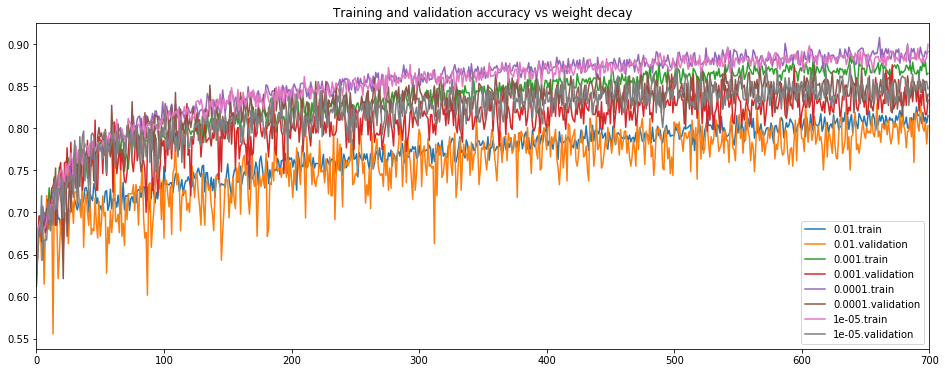

In [14]:
plt.figure(num=None, figsize=(16, 6))

for weight_decay_i,training_history in learning_history_dict.items():
    plt.plot(training_history.history['accuracy'], label= weight_decay_i +'.train')
    plt.plot(training_history.history['val_accuracy'], label= weight_decay_i + '.validation')

plt.legend()
plt.title('Training and validation accuracy vs weight decay')
plt.xlim(0, EPOCHS)
plt.show()

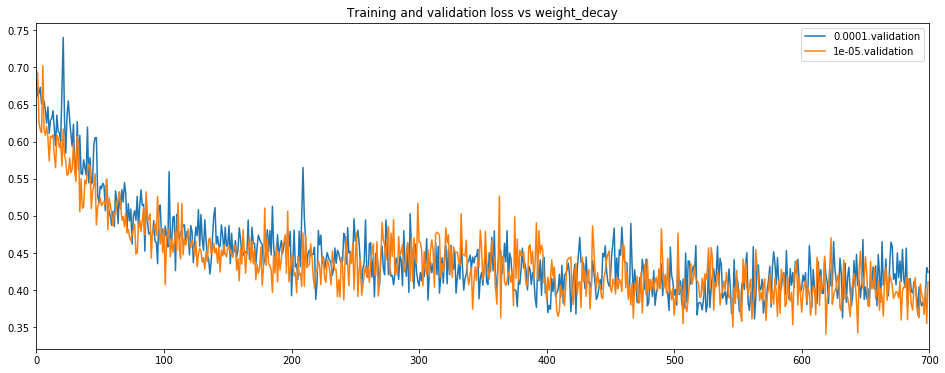

In [21]:
plt.figure(num=None, figsize=(16, 6))

#plt.plot(learning_history_dict['0.0001'].history['loss'], label= '0.0001.train')
plt.plot(learning_history_dict['0.0001'].history['val_loss'], label= '0.0001.validation')
#plt.plot(learning_history_dict['1e-05'].history['loss'], label= '1e-05.train')
plt.plot(learning_history_dict['1e-05'].history['val_loss'], label= '1e-05.validation')


plt.legend()
plt.title('Training and validation loss vs weight_decay')
plt.xlim(0, EPOCHS)
plt.show()

### Cyclical Learning rate

In [7]:
learning_history_dict = {}
training_time_dict = {}
out_of_set_test_dict = {}
lr_dict = {}
EPOCHS = 150

In [8]:
MIN_LR = 6e-4
MAX_LR = 6.6e-3
BATCH_SIZE = 32
STEP_SIZE = 8
CLR_METHOD = "triangular2"
NUM_CLR_CYCLES = EPOCHS / STEP_SIZE / 2

In [9]:
!rm -rf ./logs/
skipLogger_callback = SkipLoggerCallback(n=25)

clr_callback = CyclicLR(mode=CLR_METHOD, base_lr=MIN_LR, max_lr=MAX_LR,step_size= STEP_SIZE * (train_batches.samples/BATCH_SIZE))

In [39]:
for weight_decay_i in weight_decay_list:
    print('working with weight_decay : %f' % weight_decay_i)
    print('')
    
    sgd = optimizers.SGD(lr=MIN_LR,momentum=0.9)
    model = define_model_architecture_64_32_16(optimizer_p=sgd,weight_decay=weight_decay_i)
    
    log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    start = time.time()
    history = model.fit_generator(generator = train_batches, steps_per_epoch=train_batches.samples/BATCH_SIZE, 
                                  validation_data = validation_batches, validation_steps = validation_batches.samples/BATCH_SIZE,
                                  epochs=EPOCHS, verbose=0, workers=4, callbacks = [tb_callback, skipLogger_callback,clr_callback])
    
    training_time_dict[str(weight_decay_i)] = time.time() - start
    learning_history_dict[str(weight_decay_i)] = history
    oos_test_loss, oos_test_accuracy = get_oos_test_accuracy(model)
    print('OOS Test loss: %.4f OOS std dev: %.4f' % (oos_test_loss, oos_test_accuracy))  
    out_of_set_test_dict[str(weight_decay_i)] = (oos_test_loss, oos_test_accuracy)
    test_loss, test_accuracy = model.evaluate_generator(test_batches, workers=4, verbose=0) 
    print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))    
    print('-'*120)

working with weight_decay : 0.010000

epoch =    0    loss = 2.509810    accuracy = 0.54    val_loss = 2.611091    val_accuracy = 0.54
epoch =   25    loss = 0.888935    accuracy = 0.71    val_loss = 0.915829    val_accuracy = 0.70
epoch =   50    loss = 0.683263    accuracy = 0.76    val_loss = 0.720932    val_accuracy = 0.74
epoch =   75    loss = 0.616570    accuracy = 0.77    val_loss = 0.667383    val_accuracy = 0.78
epoch =  100    loss = 0.583748    accuracy = 0.78    val_loss = 0.615630    val_accuracy = 0.80
epoch =  125    loss = 0.554698    accuracy = 0.79    val_loss = 0.634032    val_accuracy = 0.74
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 49 images belonging to 2 classes.
Found 49 images belonging to 2 classes.
Found 50 images belo

In [40]:
out_of_set_test_dict

{'0.01': (0.79304487, 0.050289754),
 '0.001': (0.8135021, 0.04943731),
 '0.0001': (0.8060408, 0.06039933),
 '1e-05': (0.8059932, 0.06821621)}

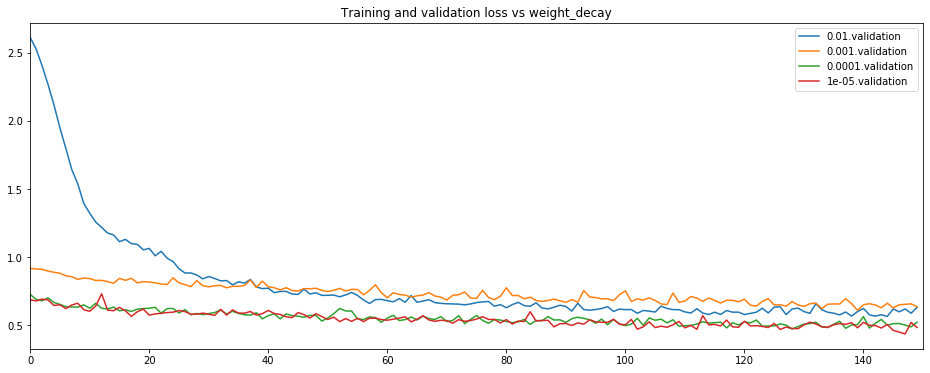

In [42]:
plt.figure(num=None, figsize=(16, 6))

for weight_decay_i,training_history in learning_history_dict.items():
    #plt.plot(training_history.history['loss'], label= weight_decay_i +'.train')
    plt.plot(training_history.history['val_loss'], label= weight_decay_i + '.validation')

plt.legend()
plt.title('Training and validation loss vs weight_decay')
plt.xlim(0, EPOCHS)
plt.show()

In [10]:
weight_decay_list = [1e-4,1e-5]

In [11]:
learning_history_dict = {}
training_time_dict = {}
out_of_set_test_dict = {}
lr_dict = {}
EPOCHS = 700

In [12]:
!rm -rf ./logs/
skipLogger_callback = SkipLoggerCallback(n=25)

lrate_callback = LearningRateScheduler(step_decay_25_864065)

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    
callback_list = [lrate_callback, tb_callback, skipLogger_callback]

In [13]:
for weight_decay_i in weight_decay_list:
    print('working with weight_decay : %f' % weight_decay_i)
    print('')
    
    sgd = optimizers.SGD(lr=0.0,momentum=0.9,nesterov=True)
    model = define_model_architecture_64_32_16(optimizer_p=sgd,weight_decay=weight_decay_i)
    
    log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    start = time.time()
    history = model.fit_generator(generator = train_batches, steps_per_epoch=train_batches.samples/BATCH_SIZE, 
                                  validation_data = validation_batches, validation_steps = validation_batches.samples/BATCH_SIZE,
                                  epochs=EPOCHS, verbose=0, workers=4, callbacks = callback_list)
    
    training_time_dict[str(weight_decay_i)] = time.time() - start
    learning_history_dict[str(weight_decay_i)] = history
    out_of_set_test_dict[str(weight_decay_i)] = get_oos_test_accuracy(model)
    test_loss, test_accuracy = model.evaluate_generator(test_batches, workers=4, verbose=0) 
    print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))    
    print('-'*120)

working with weight_decay : 0.000100



W0910 18:34:00.797948 140211630667584 deprecation.py:323] From /home/algolaptop8/anaconda3/envs/tf2-env/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


epoch =    0    loss = 0.716858    accuracy = 0.58    val_loss = 0.697725    val_accuracy = 0.61
epoch =   25    loss = 0.541624    accuracy = 0.74    val_loss = 0.611956    val_accuracy = 0.71
epoch =   50    loss = 0.486907    accuracy = 0.79    val_loss = 0.544522    val_accuracy = 0.78
epoch =   75    loss = 0.459411    accuracy = 0.80    val_loss = 0.503737    val_accuracy = 0.79
epoch =  100    loss = 0.451340    accuracy = 0.79    val_loss = 0.480713    val_accuracy = 0.82
epoch =  125    loss = 0.443124    accuracy = 0.80    val_loss = 0.475581    val_accuracy = 0.81
epoch =  150    loss = 0.407213    accuracy = 0.83    val_loss = 0.487174    val_accuracy = 0.80
epoch =  175    loss = 0.393341    accuracy = 0.83    val_loss = 0.466270    val_accuracy = 0.81
epoch =  200    loss = 0.378450    accuracy = 0.84    val_loss = 0.458730    val_accuracy = 0.83
epoch =  225    loss = 0.364714    accuracy = 0.84    val_loss = 0.423029    val_accuracy = 0.84
epoch =  250    loss = 0.37993

In [14]:
training_time_dict

{'0.0001': 3949.2630755901337, '1e-05': 3960.8865830898285}

In [15]:
out_of_set_test_dict

{'0.0001': (0.846702, 0.052257188), '1e-05': (0.8488272, 0.050567787)}

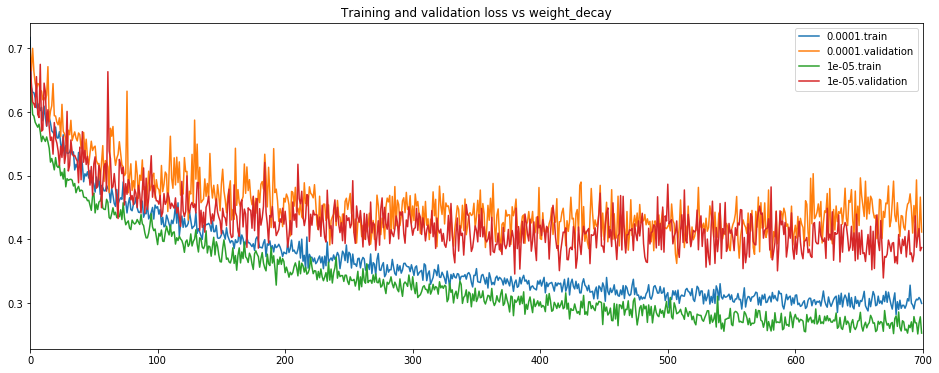

In [16]:
plt.figure(num=None, figsize=(16, 6))

for weight_decay_i,training_history in learning_history_dict.items():
    plt.plot(training_history.history['loss'], label= weight_decay_i +'.train')
    plt.plot(training_history.history['val_loss'], label= weight_decay_i + '.validation')

plt.legend()
plt.title('Training and validation loss vs weight_decay')
plt.xlim(0, EPOCHS)
plt.show()